# A Simple Neural network
## Part 2: Logistic regression (classification)

This tutorial is part 2 of the [previous tutorial on neural networks](http://peterroelants.github.io/posts/2015/05/18/Simple_neural_network_part01/). While the previous tutorial described a very simple one-input-one-output linear regression model, this model will describe a 2-class classification neural network with two input dimensions. This model is known in statistics as the [logistic regression](http://en.wikipedia.org/wiki/Logistic_regression) model.

![Image of the logistic model](https://dl.dropboxusercontent.com/u/8938051/Blog_images/SimpleANN02.png)

In [3]:
# Python imports
import numpy  # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
numpy.random.seed(seed=1)

## Logistic function

The goal to predict the target class $t$ from the input values $x$. The network is defined as having an input $x = [x_1, x_2]$ which gets transformed by the weights $w = [w_1, w_2]$ and bias $b$ to generate the output class $y$ by the formula $y = \sigma((x * w^T) + b)$. $\sigma$ is the [logistic function](http://en.wikipedia.org/wiki/Logistic_function) and is defined as:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

This logistic function maps the input $z$ to an output between $0$ and $1$ as is illustrated in the figure below.

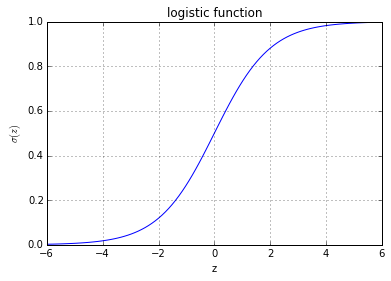

In [7]:
# Define the logistic function
def logistic(z): return 1 / (1 + numpy.exp(-z))

# Plot the logistic function
z = numpy.linspace(-6,6,100)
plt.plot(z, logistic(z), 'b-')
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.title('logistic function')
plt.grid()
plt.show()

## Define the cost function

The output of the model $y = \sigma((x * w) + b)$ can be interpreted as a probability $y$ that sample $x$ belongs to one class $(t=1)$, or probability $1-y$ that $x$ belongs to the other class $(t=0)$ in a two class classification problem. We note this down as: $p(t=1| x, \theta) = \sigma((x * w) + b) = y$, where $\theta$ is the set of model parameters $(w,b)$.

This model will be optimized by maximizing the likelihood that a given set of parameters $\theta$ can predict the correct class:

$$\underset{\theta}{\text{argmax}} \sum_{i=1}^{n} \mathcal{L}(\theta|t_i,x_i)$$

To optimize this model so that $y$ should be equal to $t$ for as many samples as possible we don't use the squared error cost function as in linear regression but we use the [cross-entropy error function](http://en.wikipedia.org/wiki/Cross_entropy) (also known as log-loss):

$$\begin{split}
\xi(t,y) = & - \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right] \\
& - \sum_{i=1}^{n} \left[ t_i log(\sigma((x_i * w) + b)) + (1-t_i)log(1-\sigma((x_i * w) + b)) \right]
\end{split}$$

For $n$ samples in the training set. This function looks complicated but there are a couple of reasons that this function is used as a cost function for logistic regression. First of all it can be rewritten as:

$$ \xi(t_i,y_i) = 
   \begin{cases}
   -log(y_i) & \text{if } t_i = 1 \\
   -log(1-y_i) & \text{if } t_i = 0
  \end{cases}$$
  
Which in the case of $t_i=1$ is $0$ if $y_i=1$ $(-log(1)=0)$ and goes to infinity as $y_i \rightarrow 0$ $(\underset{y \rightarrow 0}{\text{lim}}  -log(y) = +\infty)$. The reverse effect is happening if $t_i=0$.  
So what we end up with is a cost function that is $0$ if the probability to predict the correct class is $1$, and goes to infinity as the probability to predict the correct class goes to $0$.

Notice that the cost function $\xi(t_i,y_i)$ is equal to the negative [log probability](http://en.wikipedia.org/wiki/Log_probability) that $x_i$ is classified as its correct class:  
$-log(p(t_i=1| x_i,w,b)) = -log(y_i)$,  
$-log(p(t_i=0| x_i,w,b)) =$ $-log(1-y_i)$.

By minimizing the negative log probability we will maximize the log probability.

Note that since $t_i$ can only be $0$ or $1$, we can rewrite $\xi(t_i,y_i)$ as:
$$ \xi(t_i,y_i) = -t_i log(y_i) - (1-t_i)log(1-y_i) $$

Which will give $\xi(t,y) = - \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$ if we sum over all $n$ samples.



Another reason to use the cross-entropy function is that in simple logistic regression this results in a [convex](http://en.wikipedia.org/wiki/Convex_function) cost function, of which the global minimum will be easy to find. Note that this is not necessaraly the case anymore in multilayer neural networks.

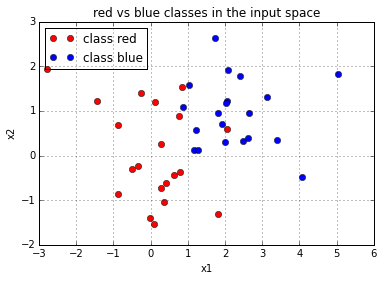

In [5]:
nb_of_samples_per_class = 20
red_mean = [0,0]
blue_mean = [2,1]
x_red = numpy.random.randn(nb_of_samples_per_class, 2) + red_mean
x_blue = numpy.random.randn(nb_of_samples_per_class, 2) + blue_mean


# Plot the target t versus the input x
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('red vs blue classes in the input space')
plt.show()